## Run trajectory prediction on polynomial manifold data
This is a tutorial on using the `TrajPred` to predict trajectories of a dynamical system with a polynomial slow manifold given as:
$$\dot{x}_1 = \mu x_1$$
$$\dot{x}_2 = \lambda\left(x_2-x_1^2\right)$$
as studied in [[1]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0150171) and [[2]](https://www.nature.com/articles/s41467-018-07210-0).

In particular, the data is as used in \[2\]. The data consists of trajectories, each with 51 indexed states of 2 dimensions. Thus, each trajectory is a rollout of an initial state $x_0$ through indexes $\left[x_1,x_2,\cdots,x_{50}\right]$. We will learn the training data trajectories, validate and test the model on validation and test trajectories, respectively, then use the learned model to predict the unknown trajectories for new initial states.

In [1]:
from dlkoopman.traj_pred import *
from dlkoopman import utils

### Load data

In [2]:
import pickle
with open('./data.pkl', 'rb') as f:
    data = pickle.load(f)

The resulting `data` dictionary has keys that are required by [`TrajPredDataHandler`](https://galoisinc.github.io/dlkoopman/traj_pred.html#dlkoopman.traj_pred.TrajPredDataHandler). The contents are:
- `'Xtr'` of shape `(10500,51,2)`. This corresponds to 10,500 training trajectories, each containing 2-dimensional states from $x_0$ to $x_{50}$.
- `'Xva'` of shape `(1000,51,2)`, corresponding to 1000 validation trajectories.
- `'Xte'` of shape `(500,51,2)`, corresponding to 500 validation trajectories.

We'll now create a data handler. This has required argument `Xtr`, since training data must be provided. Optionally, we can also provide validation and test data. 

In [3]:
dh = TrajPredDataHandler(
    Xtr=data['Xtr'],
    Xva=data['Xva'],
    Xte=data['Xte']
)

The following is an optional step used to seed the run. Since neural nets initialize their parameters randomly, setting the same random seed ensures reproducibility of results as long as the same `torch` version is used (we used `1.12.1`). If you do not get the exact same results as ours, don't worry, the basic aim of the tutorials is for you to understand how things work.

In [4]:
utils.set_seed(10)

### Create trajectory predictor object
This is documented [here](https://galoisinc.github.io/dlkoopman/traj_pred.html#dlkoopman.traj_pred.TrajPred).

In [5]:
tp = TrajPred(
    dh = dh,
    encoded_size = 50
)

Log file = /Users/sourya/work/Essence/dlkoopman/examples/traj_pred_polynomial_manifold/log_574vPLPVXjGckkJwqDQ2QD.log


It creates an instance and prints the log file path (yours will be different).

Thus, the encoded vector $y$ will be $50$-dimensional. Since by default `encoder_hidden_layers = [100]`, the overall network looks like:
<figure><center>
<img src="polynomial_manifold_ae_architecture.png" width=480/>
</center></figure>

### Training and testing
This uses all the default training settings, which can be found [here](https://galoisinc.github.io/dlkoopman/traj_pred.html#dlkoopman.traj_pred.TrajPred.train_net).

In [6]:
tp.train_net()
tp.test_net()

100%|██████████| 10/10 [01:06<00:00,  6.69s/it]


### Visualizing results
Let's plot:
- The loss for the prediction task.
- The overall loss, which is a linear combination of different losses, and is optimized during training via gradient descent.

The metrics are documented [here](https://galoisinc.github.io/dlkoopman/metrics.html).

Saving figure /Users/sourya/work/Essence/dlkoopman/examples/traj_pred_polynomial_manifold/plot_574vPLPVXjGckkJwqDQ2QD_pred_loss.png
Saving figure /Users/sourya/work/Essence/dlkoopman/examples/traj_pred_polynomial_manifold/plot_574vPLPVXjGckkJwqDQ2QD_total_loss.png


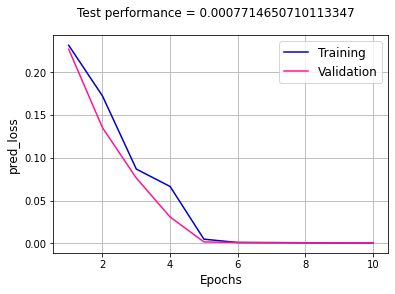

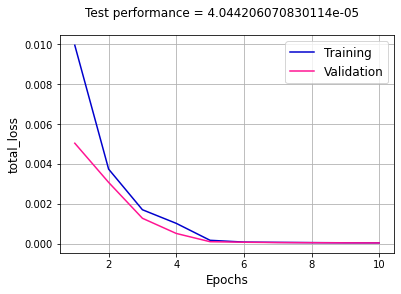

In [7]:
utils.plot_stats(tp, ['pred_loss', 'total_loss'])

(Your save paths will be different)

`loss` and `pred_loss` go down as expected and the final losses on test data are low. Keep in mind that losses are measured for the *entire trajectory* of 51 states, which the trained model is generating from just the initial state.

Let's see if we can do better.

### Optimizing
Let's tweak the settings and re-run for a longer time. This may take several minutes.

  0%|          | 0/50 [00:00<?, ?it/s]

Log file = /Users/sourya/work/Essence/dlkoopman/examples/traj_pred_polynomial_manifold/log_KybigaN4XE9o8b6hbHucbu.log


100%|██████████| 50/50 [07:17<00:00,  8.76s/it]


Saving figure /Users/sourya/work/Essence/dlkoopman/examples/traj_pred_polynomial_manifold/plot_KybigaN4XE9o8b6hbHucbu_pred_loss.png
Saving figure /Users/sourya/work/Essence/dlkoopman/examples/traj_pred_polynomial_manifold/plot_KybigaN4XE9o8b6hbHucbu_total_loss.png


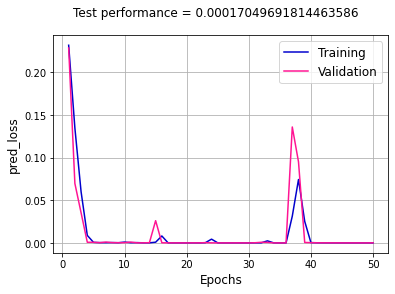

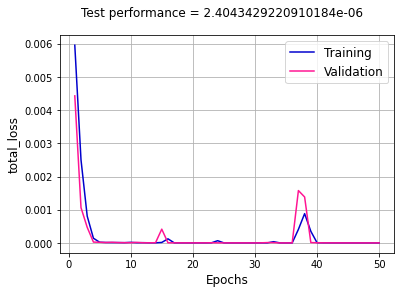

In [8]:
utils.set_seed(10)

tp = TrajPred(
    dh = dh,
    encoded_size = 50,
    encoder_hidden_layers = [20,50]
)

tp.train_net(
    numepochs = 50,
    batch_size = 125,
    weight_decay = 1e-6
)

tp.test_net()

utils.plot_stats(tp, ['pred_loss', 'total_loss'])

The total loss on test data is an order of magnitude better.

If you are wondering how we arrived at a good configuration, it is by running hyperparameter search. Check out the tutorial [here](./hyp_search.ipynb).

### Unknown trajectory predictions
Let's use the trained `TrajPred` model to generate trajectories for new initial states $[0.5,0.5]$ and $[-0.4,0.3]$.

In [9]:
tp.predict_new([[0.5,0.5], [-0.4,0.3]])

tensor([[[ 0.5000,  0.5000],
         [ 0.4945,  0.4930],
         [ 0.4944,  0.4920],
         [ 0.4953,  0.4882],
         [ 0.4949,  0.4838],
         [ 0.4951,  0.4787],
         [ 0.4947,  0.4737],
         [ 0.4943,  0.4689],
         [ 0.4940,  0.4640],
         [ 0.4937,  0.4593],
         [ 0.4933,  0.4547],
         [ 0.4930,  0.4501],
         [ 0.4927,  0.4457],
         [ 0.4924,  0.4413],
         [ 0.4920,  0.4371],
         [ 0.4917,  0.4329],
         [ 0.4914,  0.4287],
         [ 0.4910,  0.4247],
         [ 0.4907,  0.4208],
         [ 0.4904,  0.4169],
         [ 0.4900,  0.4131],
         [ 0.4897,  0.4093],
         [ 0.4894,  0.4057],
         [ 0.4890,  0.4021],
         [ 0.4887,  0.3986],
         [ 0.4884,  0.3951],
         [ 0.4880,  0.3917],
         [ 0.4877,  0.3884],
         [ 0.4874,  0.3851],
         [ 0.4871,  0.3819],
         [ 0.4867,  0.3788],
         [ 0.4864,  0.3757],
         [ 0.4861,  0.3727],
         [ 0.4857,  0.3698],
         [ 0.4

### Checking the eigendecomposition
The eigendecomposition of the Koopman matrix (i.e. the linear layer) is not used in trajectory prediction, since the linear layer directly computes trajectories. However, since the eigendecomposition characterizes the system, let's check it out. The `Lambda` attribute is a diagonal matrix containing the discrete index eigenvalues as its diagonal elements.

In [10]:
print('Discrete index eigenvalues:')
print(tp.Lambda)

Discrete index eigenvalues:
tensor([ 0.9989+0.0000j,  0.9798+0.0000j,  0.1869+0.5236j,  0.1869-0.5236j,
         0.2636+0.4724j,  0.2636-0.4724j, -0.2441+0.4669j, -0.2441-0.4669j,
        -0.2989+0.3773j, -0.2989-0.3773j,  0.0269+0.4643j,  0.0269-0.4643j,
        -0.1009+0.4432j, -0.1009-0.4432j, -0.4837+0.0000j, -0.3939+0.2500j,
        -0.3939-0.2500j, -0.3898+0.1841j, -0.3898-0.1841j, -0.4178+0.0000j,
        -0.1308+0.3477j, -0.1308-0.3477j,  0.0036+0.3567j,  0.0036-0.3567j,
         0.2659+0.3086j,  0.2659-0.3086j,  0.4231+0.1010j,  0.4231-0.1010j,
         0.2987+0.2100j,  0.2987-0.2100j,  0.3452+0.0904j,  0.3452-0.0904j,
         0.1827+0.2741j,  0.1827-0.2741j,  0.2817+0.1238j,  0.2817-0.1238j,
        -0.1779+0.1954j, -0.1779-0.1954j, -0.2863+0.0840j, -0.2863-0.0840j,
        -0.2654+0.0000j, -0.0542+0.1823j, -0.0542-0.1823j,  0.1778+0.0000j,
         0.0807+0.1250j,  0.0807-0.1250j,  0.0613+0.0000j, -0.1260+0.0359j,
        -0.1260-0.0359j, -0.1197+0.0000j])


Notice that the dominant eigenvalue is $\sim1$, which ensures a stable system. Also note that there are 50 eigenvalues, since `encoded_size = 50`.